In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, get_scorer_names
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_graphviz
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import random
from numpy import log
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [43]:
df = pd.read_csv('ObesityDataSet-1.csv')
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [44]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [45]:
def combine_weight_category(row):
    if row in ['Overweight_Level_I', 'Overweight_Level_II']:
        return 'Overweight'
    elif row in ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']:
        return 'Obesity'
    elif row == 'Normal_Weight':
        return 'Normal'
    elif row == 'Insufficient_Weight':
        return 'Underweight'
    else:
        return row

df['weight'] = df['NObeyesdad'].apply(combine_weight_category)
df['weight'].value_counts()
df.drop(columns=['Weight'], inplace=True)
df.drop(columns=['Height'], inplace=True)
df.drop(columns=['NObeyesdad'], inplace=True)

In [46]:
def clean_split_data(df, target, train_size=0.80, tune_size=0.20, random_state=2):
    # Fill missing numeric values
    df = df.fillna(df.mean(numeric_only=True))

    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Identify categorical and continuous columns in X
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Scale continuous variables
    scaler = StandardScaler()
    X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

    # One-hot encode categorical variables
    dummies = pd.get_dummies(X[categorical_cols], drop_first=True)
    X = pd.concat([X.drop(columns=categorical_cols), dummies], axis=1)

    # Train/temp split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    
    # Split the temporary set into tuning and testing sets
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)

    return X_train, X_tune, X_test, y_train, y_tune, y_test

X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(df, 'weight')

In [47]:
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)

In [48]:
scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro']
#only go to 5, because everything after is diminishing returns
param={"max_depth" : [1,2,3,4,5,6,7,8,9,10],
           }

In [49]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1000, n_jobs=-1, class_weight='balanced')
#search = GridSearchCV(clf, param, scoring=scoring, n_jobs=1, cv=kf, refit='balanced_accuracy', return_train_score=True)
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "max_depth": [4, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=1000, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=20,  # number of random combinations to try
    scoring = ['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro'],
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    refit='balanced_accuracy'
)


In [50]:
model = search.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, random_state=1000)


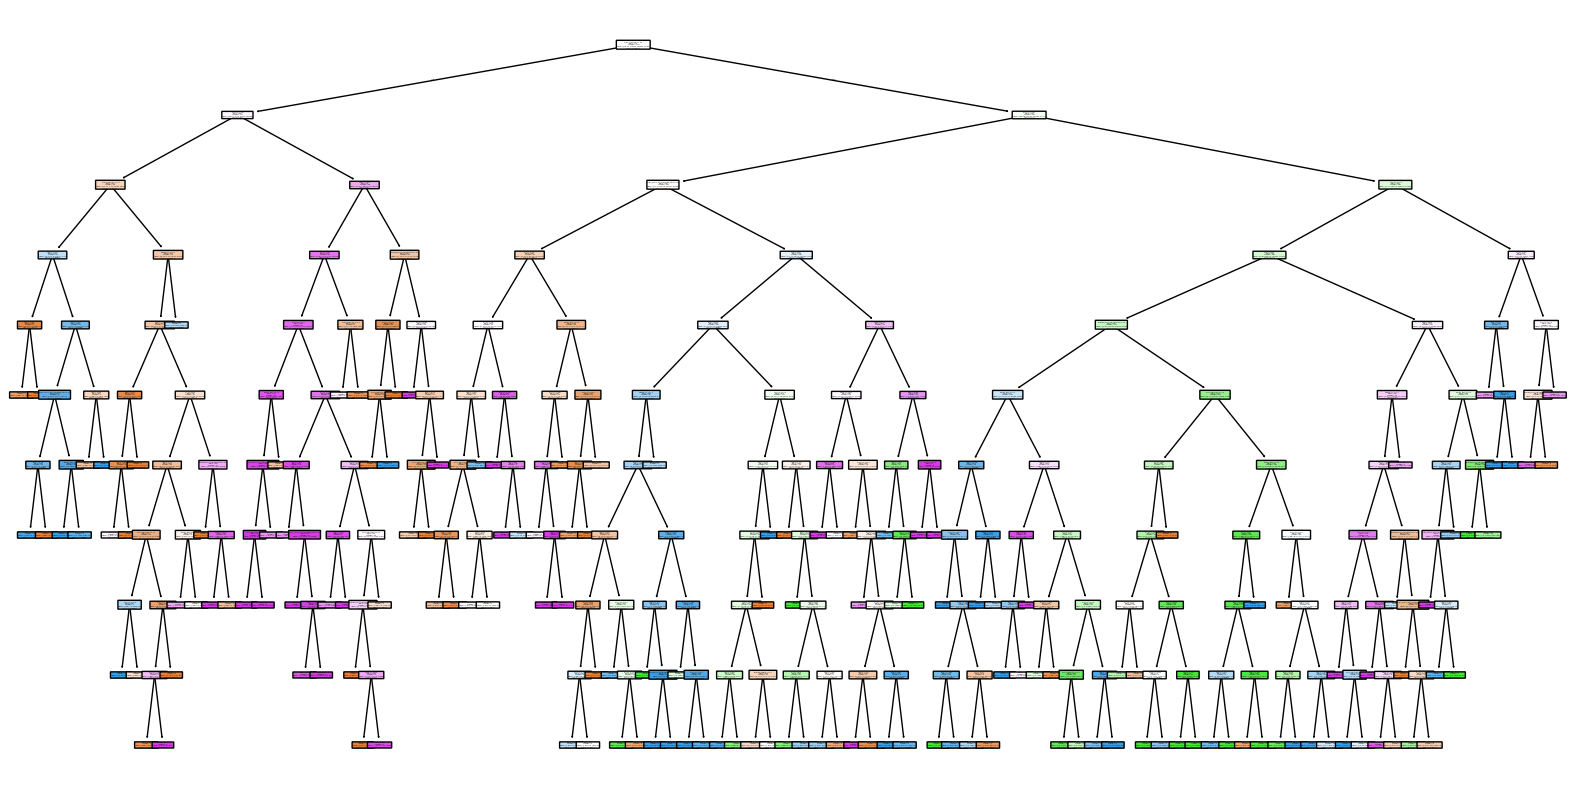

In [55]:
best = model.best_estimator_
print(best)
plt.figure(figsize=(20, 10))
# Visualize the first tree in the random forest
plot_tree(
	best.estimators_[0],
	feature_names=X_train.columns,
	class_names=[str(label) for label in y_train.unique()],
	filled=True,
	rounded=True
)
plt.show()

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      4  0.811016  0.804064  0.804064  0.791636    0.019065  0.014912   
1      6  0.768938  0.761599  0.761599  0.751198    0.018430  0.010724   
2      8  0.791458  0.786467  0.786467  0.774525    0.020511  0.013540   
3     10  0.836479  0.822690  0.822690  0.816837    0.018693  0.017301   

   bal_accSD      f1SD  
0   0.014912  0.020091  
1   0.010724  0.014377  
2   0.013540  0.018568  
3   0.017301  0.020157  


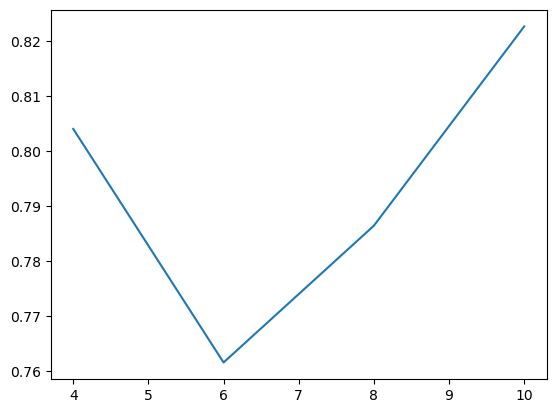

In [52]:
np.random.seed(1)
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)
plt.plot(final_model['depth'], final_model['bal_acc'], label='Accuracy')

                                    importance
Age                                   0.171223
NCP                                   0.092358
FAF                                   0.090213
TUE                                   0.090100
CH2O                                  0.089308
FCVC                                  0.084617
family_history_with_overweight_yes    0.082261
CAEC_Frequently                       0.061333
CAEC_Sometimes                        0.050340
Gender_Male                           0.040258
MTRANS_Public_Transportation          0.037045
FAVC_yes                              0.026118
CALC_Sometimes                        0.025847
CALC_no                               0.023749
SCC_yes                               0.009518
MTRANS_Walking                        0.007976
CALC_Frequently                       0.007682
CAEC_no                               0.007071
SMOKE_yes                             0.002488
MTRANS_Motorbike                      0.000469
MTRANS_Bike  

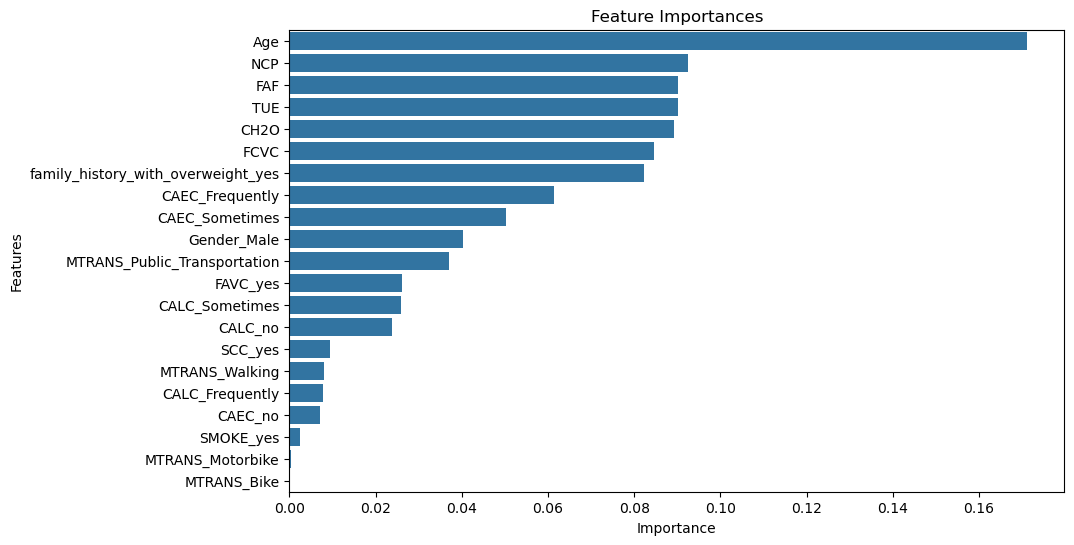

In [53]:
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [56]:
tune_predictions = pd.DataFrame(model.predict(X_tune), columns=['Predicted_Label']) 

percentages = tune_predictions['Predicted_Label'].value_counts(normalize=True) * 100

# Convert to a table format
table = percentages.reset_index()
table.columns = ['Label', 'Percentage']

# Print the table
print("Percentage of Each Predicted Label:")
print(table)

Percentage of Each Predicted Label:
         Label  Percentage
0      Obesity   47.619048
1       Normal   19.047619
2   Overweight   19.047619
3  Underweight   14.285714


Confusion Matrix


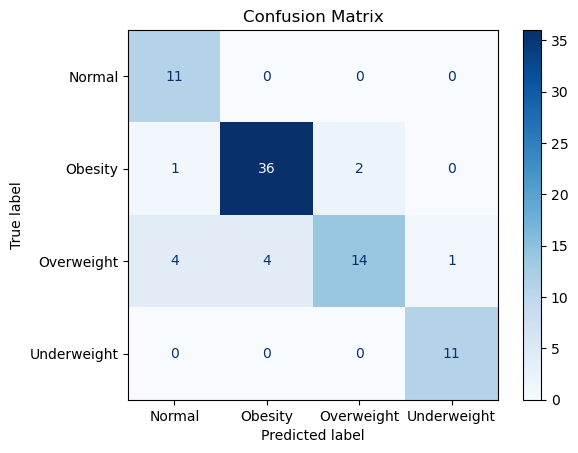

In [57]:
print("Confusion Matrix")
cm = metrics.confusion_matrix(y_tune, tune_predictions['Predicted_Label'], labels=best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
